# Bayesian Demand Models for Dynamic Price Optimization

In this notebook, we demonstrate how simple demand models can be fitted using a probabilistic programming framework, specifically PyMC3.

This type of models can be useful in dynamic pricing applications. For example, it can be combined with the Thompson sampling algorithm.

In [2]:
import pymc3 as pm
from pymc3 import  *
import theano
import theano.tensor as tt
print('Running on PyMC3 v{}'.format(pm.__version__))

import numpy as np
from scipy import stats
from matplotlib import pylab as plt
import seaborn as sns
sns.set_style("whitegrid")

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Running on PyMC3 v3.9.3


# Example 1: Poisson-Gamma Demand Model

We consider the following scenario:
* The seller offers some product to the market at price $p_t$ for time step $t$ 
* Prices are limited to some discrete set $p_1, \ldots, p_k$ 
* For a given price, we have observed Poisson distributed demand samples $d_1, \ldots, d_n$
* We assume that the prior demand distribution is gamma

The code snippet below shows how to compute the posterior demand distriution for a given price under the above assumptions. 

In [ ]:
d0 = [20, 28, 24, 20, 23]    # observed demand samples for a certain price (n = 5)

prior_a = 15
prior_b = 1
with pm.Model() as m:
    d = pm.Gamma('theta', prior_a, prior_b)          # prior distribution
    pm.Poisson('d0', d, observed = d0)               # likelihood
    samples = pm.sample(1000)                        # draw samples from the posterior

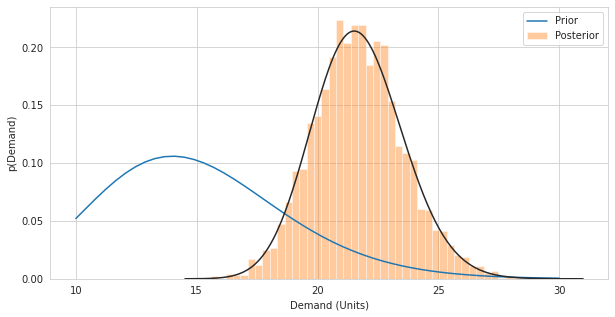

In [4]:
x = np.linspace(10, 30, 50)

fig = plt.figure(figsize=(10, 5))
sns.lineplot(x, stats.gamma.pdf(x, prior_a), label='Prior')
sns.distplot(samples.get_values('theta'), fit=stats.gamma, kde=False, label='Posterior')
plt.ylabel('p(Demand)')
plt.xlabel('Demand (Units)')
plt.legend()
plt.show()

# Example 2: Contsant-Elasticity Demand Model

* The second scenario assumes the constan-elasticity model. 
* We observe price-demand pairs and fit the model $d = b\cdot p^{-c}$ where $c$ is the elasticity coeffecient. 
* We use the logarithmic form of the model for stability and convenience: $\log d = \log b - c \cdot \log p$

In [ ]:
# (offered price, $) : (observed demand, units) pairs
price_demand = { 
    15: 20,
    14: 18,
    13: 35,
    12: 50,
    11: 65
}

p0, d0 = list(price_demand.keys()), list(price_demand.values())

with pm.Model() as m:
    log_b = pm.Normal('log_b', sd = 5)                # priors
    c = pm.HalfNormal('c', sd = 5)                    # assume the elasticty to be non-negative

    log_d = log_b - c * np.log(p0)                    # demand model
    pm.Poisson('d0', np.exp(log_d), observed = d0)    # likelihood
    s = pm.sample(1000)                               # inference

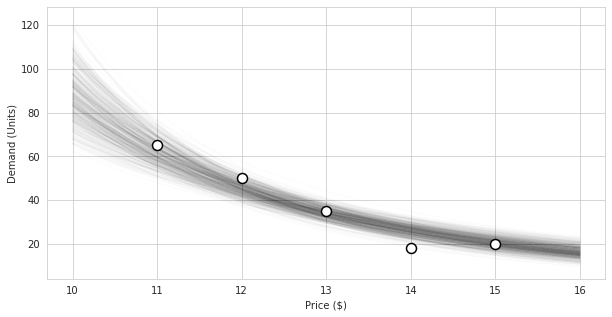

In [12]:
p = np.linspace(10, 16)   # price range
d_means = np.exp(s.log_b - s.c * np.log(p).reshape(-1, 1))[:, :500]

fig = plt.figure(figsize=(10, 5))
plt.plot(p, d_means, c = 'k', alpha = 0.01)
plt.plot(p0, d0, 'ko', markeredgewidth=1.5, markerfacecolor='w', markersize=10)
plt.xlabel('Price ($)')
plt.ylabel('Demand (Units)')
plt.show()

# Example 3: Two Related Products

* The third example shows how the model can be extended to incorporate cross-product dependencies. 
* We assume two products and impose correlations between their elasticity coeffecients.

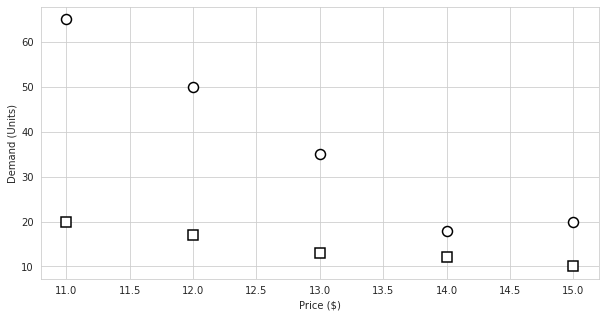

In [13]:
price_demand = [
    { 15: 20, 14: 18, 13: 35, 12: 50, 11: 65}, # product 1
    { 15: 10, 14: 12, 13: 13, 12: 17, 11: 20}  # product 2
]

p01, d01 = list(price_demand[0].keys()), list(price_demand[0].values())
p02, d02 = list(price_demand[1].keys()), list(price_demand[1].values())

fig = plt.figure(figsize=(10, 5))
plt.plot(p01, d01, 'ko', markeredgewidth=1.5, markerfacecolor='w', markersize=10)
plt.plot(p02, d02, 'ks', markeredgewidth=1.5, markerfacecolor='w', markersize=10)
plt.xlabel('Price ($)')
plt.ylabel('Demand (Units)')
plt.show()

In [ ]:
p, d = np.vstack([p01, p02]), np.vstack([d01, d02]) 

with pm.Model() as m:
    # priors
    log_b_mu, log_b_cov = np.zeros(2), 10*np.eye(2)
    log_b = pm.MvNormal('log_b', mu=log_b_mu, cov=log_b_cov, shape=(2,))  

    c_mu = np.zeros(2)
    c_cov = 10 * np.array([[  1.0,  0.9], 
                           [  0.9,  1.0]])
    c = pm.MvNormal('c', mu=c_mu, cov=c_cov, shape=(2,))

    log_d1 = log_b - c * np.log(p.T)                    # demand model
    pm.Poisson('d0', np.exp(log_d1), observed = d.T)    # likelihood
    s = pm.sample(1000)                                 # inference

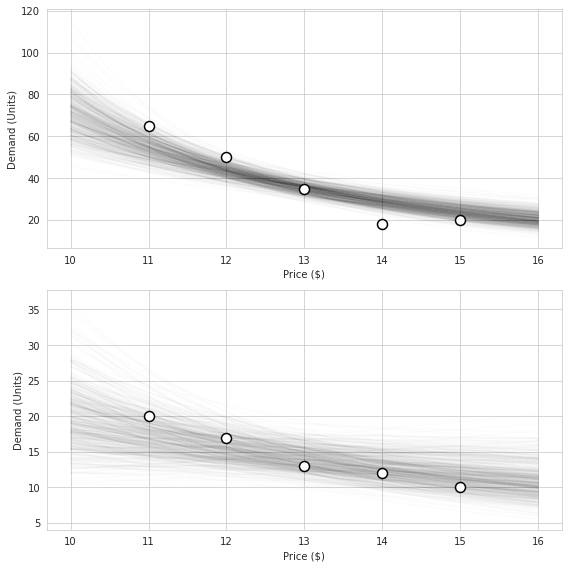

In [15]:
p = np.linspace(10, 16)   # price range
d_means = [
    np.exp(s.log_b[:, i] - s.c[:, i] * np.log(p).reshape(-1, 1))[:, :500] for i in [0, 1]
]

fig, ax = plt.subplots(2, 1, figsize=(8, 8))
ax[0].plot(p, d_means[0], c = 'k', alpha = 0.01)
ax[0].plot(p01, d01, 'ko', markeredgewidth=1.5, markerfacecolor='w', markersize=10)
ax[0].set_xlabel('Price ($)')
ax[0].set_ylabel('Demand (Units)')

ax[1].plot(p, d_means[1], c = 'k', alpha = 0.01)
ax[1].plot(p02, d02, 'ko', markeredgewidth=1.5, markerfacecolor='w', markersize=10)
ax[1].set_xlabel('Price ($)')
ax[1].set_ylabel('Demand (Units)')

plt.tight_layout()
plt.show()